# This Notebook uses ATAC-seq generated data

Refer to `ATAC-py.ipynb` for prior data analysis pipeline

In [1]:
library(repr)
options(repr.plot.width=7, repr.plot.height=7)

In [2]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [6]:
library(DESeq2)
library(apeglm)
library(EnhancedVolcano)
library(pheatmap)

# Promoter region DESeq



In [8]:
setwd('/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/')

In [9]:
peak_cnts_gen <- read.table("diffbind_consensu_min2overlap_readcounts_geneRegion.txt", header=F, stringsAsFactors = F)

In [11]:
peak_cnts_gen <- peak_cnts_gen %>% select(19,4:15)

In [13]:
colnames(peak_cnts_gen) <- c("gene_id","A1", "A2", "A3","A4","A5","A6","A7","A8","A9","A10","A11","A12")

In [17]:
peak_cnts_gen <- peak_cnts_gen %>% group_by(gene_id) %>% summarise_all(sum) # group peaks into one gene per row

In [19]:
peak_cnts_gen <- peak_cnts_gen %>% column_to_rownames('gene_id') # column to row

In [20]:
peak_cnts_gen %>% str

'data.frame':	14434 obs. of  12 variables:
 $ A1 : int  93 23 200 297 145 89 348 401 97 42 ...
 $ A2 : int  85 10 169 205 192 71 249 330 100 24 ...
 $ A3 : int  79 32 161 224 161 65 276 335 92 28 ...
 $ A4 : int  65 13 124 209 178 49 287 391 113 16 ...
 $ A5 : int  121 11 223 230 176 78 332 465 78 28 ...
 $ A6 : int  104 20 290 405 224 160 425 549 120 38 ...
 $ A7 : int  109 14 140 237 101 111 298 311 102 23 ...
 $ A8 : int  145 27 197 278 177 116 440 459 157 24 ...
 $ A9 : int  292 44 429 564 315 182 818 800 362 56 ...
 $ A10: int  121 6 281 335 242 122 500 538 246 45 ...
 $ A11: int  202 18 365 281 133 77 771 486 489 37 ...
 $ A12: int  219 15 313 252 99 60 687 417 433 25 ...


In [21]:
all.sample.annotation <- read.table('ATACseqSampleName.csv', stringsAsFactors=F, col.names = c('sample', 'group'))

In [22]:
all.sample.annotation %>% t

sample,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
group,ES,ES,H1,H1,H4,H4,H16,H16,H24,H24,D5,D5


In [23]:
# sample names for WT at different time points: 15H , 1D, 2D, 4D, 7D
cols3 <- all.sample.annotation %>% pull(sample)

In [25]:
cnts3 <- peak_cnts_gen[,cols3]

In [26]:
gtf_lookup = read.csv('/gpfs/commons/groups/sanjana_lab/cdai/ref_genome/gencode.v31.primary_assembly.annotation.gene_idTOgene_name.txt') #gencode gene_id to gene_name lookup

In [27]:
cnts3 %>% head

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003.14,93,85,79,65,121,104,109,145,292,121,202,219
ENSG00000000005.6,23,10,32,13,11,20,14,27,44,6,18,15
ENSG00000000457.14,200,169,161,124,223,290,140,197,429,281,365,313
ENSG00000000460.17,297,205,224,209,230,405,237,278,564,335,281,252
ENSG00000000938.13,145,192,161,178,176,224,101,177,315,242,133,99
ENSG00000000971.15,89,71,65,49,78,160,111,116,182,122,77,60


In [28]:
gene_ids3 = rownames_to_column(cnts3,'gene_id')[,1:2]

In [29]:
gtf_lookup$gene_id <- as.character(gtf_lookup$gene_id)
gene_names3 = left_join(gene_ids3, gtf_lookup, 'gene_id') %>% pull(gene_name) %>% as.character

In [30]:
gene_names3 %>% str

 chr [1:14434] "TSPAN6" "TNMD" "SCYL3" "C1orf112" "FGR" "CFH" "GCLC" ...


In [31]:
coldata3 <- all.sample.annotation %>% column_to_rownames('sample')

In [32]:
coldata3 %>% t

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
group,ES,ES,H1,H1,H4,H4,H16,H16,H24,H24,D5,D5


In [33]:
cnts3 %>% head

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003.14,93,85,79,65,121,104,109,145,292,121,202,219
ENSG00000000005.6,23,10,32,13,11,20,14,27,44,6,18,15
ENSG00000000457.14,200,169,161,124,223,290,140,197,429,281,365,313
ENSG00000000460.17,297,205,224,209,230,405,237,278,564,335,281,252
ENSG00000000938.13,145,192,161,178,176,224,101,177,315,242,133,99
ENSG00000000971.15,89,71,65,49,78,160,111,116,182,122,77,60


In [34]:
coldata3 %>% t
cnts3 %>% colnames %>% t

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
group,ES,ES,H1,H1,H4,H4,H16,H16,H24,H24,D5,D5


A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12


In [35]:
dds3 <- DESeqDataSetFromMatrix(countData = cnts3, colData = coldata3, design = ~ group)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

In [36]:
all(rownames(dds3) == gene_ids3$gene_id) # make sure all gene_ids are the same as the gene ids in dds

[1] TRUE

In [37]:
mcols(dds3) <- cbind(mcols(dds3), 'gene_name' = gene_names3) # adding gene_names to counts dds

In [38]:
keep3 <- rowSums(counts(dds3)) >= 10 # pre-analysis filter to remove very low read count genes
dds3 <- dds3[keep3,]

In [39]:
dim(dds3)

[1] 14434    12

In [40]:
counts(dds3) %>% head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
ENSG00000000003.14,93,85,79,65,121,104,109,145,292,121,202,219
ENSG00000000005.6,23,10,32,13,11,20,14,27,44,6,18,15
ENSG00000000457.14,200,169,161,124,223,290,140,197,429,281,365,313
ENSG00000000460.17,297,205,224,209,230,405,237,278,564,335,281,252
ENSG00000000938.13,145,192,161,178,176,224,101,177,315,242,133,99
ENSG00000000971.15,89,71,65,49,78,160,111,116,182,122,77,60


In [41]:
dds3 <- DESeq(dds3) # build model

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [42]:
resultsNames(dds3) # model coefficients

[1] "Intercept"       "group_ES_vs_D5"  "group_H1_vs_D5"  "group_H16_vs_D5"
[5] "group_H24_vs_D5" "group_H4_vs_D5"

### Volcano plots

#### 1H vs. ES

In [43]:
res3a <- results(dds3, contrast = c('group','H1','ES')) # modelling ES vs. +DOX

# add gene_name to result
if (all(rownames(res3a) == rownames(dds3))) {
    res3a.df <- cbind(res3a, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))
}  else {
    print("Rownames don't match!")
}

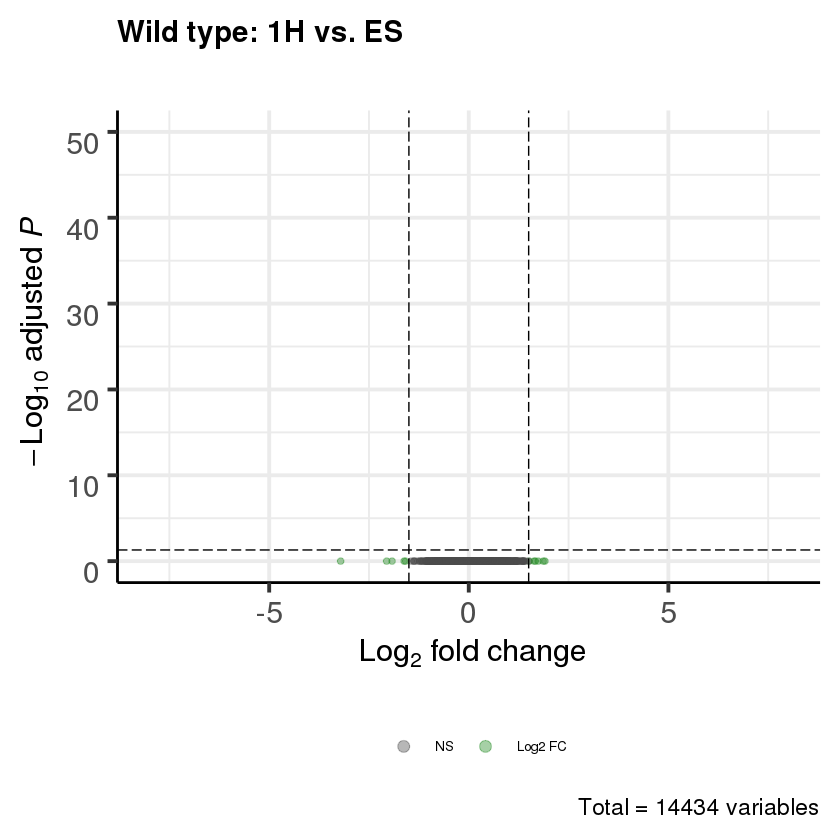

In [45]:
EnhancedVolcano(res3a.df, lab = res3a.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-8,8), ylim=c(0,50),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 1H vs. ES", subtitle="", pCutoff = 0.05, FCcutoff = 1.5,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

#### 4H vs. ES

In [46]:
res3b <- results(dds3, contrast = c('group','H4','ES'))

# add gene_name to result
if (all(rownames(res3b) == rownames(dds3))) {
    res3b.df <- cbind(res3b, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))   
}  else {
    print("Rownames don't match!")
}

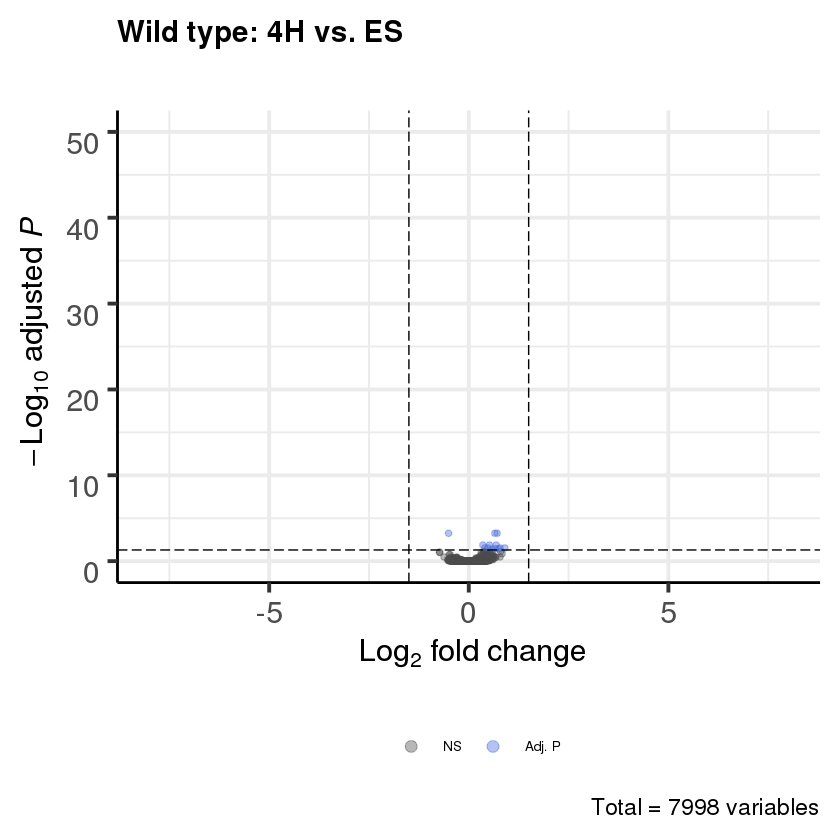

In [47]:
EnhancedVolcano(res3b.df, lab = res3b.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-8,8), ylim=c(0,50),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 4H vs. ES", subtitle="", pCutoff = 0.05, FCcutoff = 1.5,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

#### H16 vs. ES

In [48]:
res3c <- results(dds3, contrast = c('group','H16','ES'))

# add gene_name to result
if (all(rownames(res3c) == rownames(dds3))) {
    res3c.df <- cbind(res3c, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))   
}  else {
    print("Rownames don't match!")
}

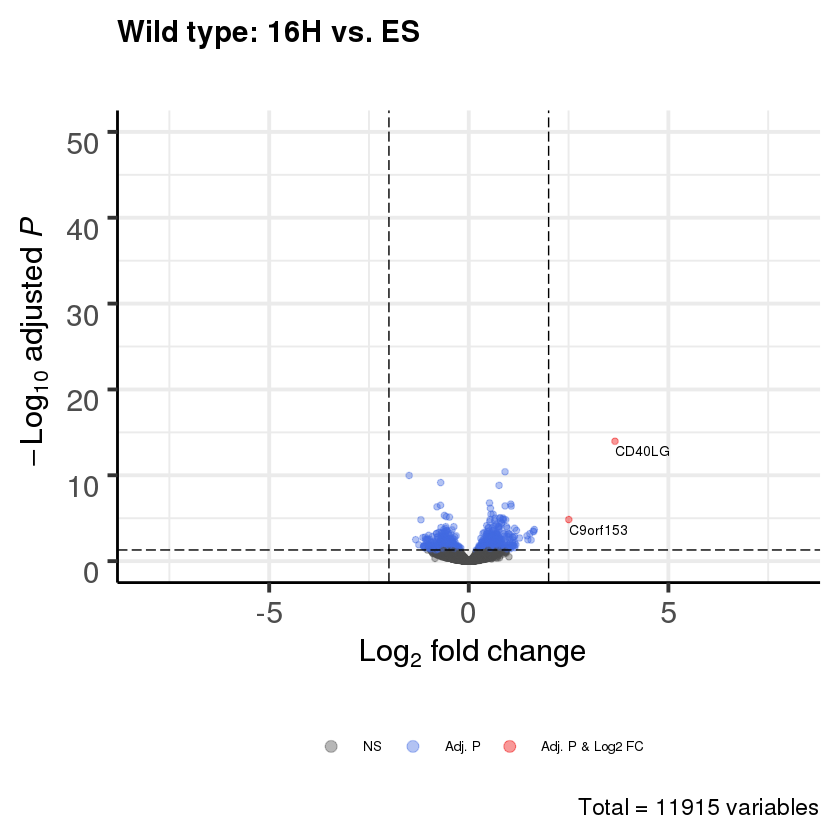

In [49]:
EnhancedVolcano(res3c.df, lab = res3c.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-8,8), ylim=c(0,50),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 16H vs. ES", subtitle="", pCutoff = 0.05, FCcutoff = 2,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

#### 24H vs. ES

In [50]:
res3d <- results(dds3, contrast = c('group','H24','ES'))

# add gene_name to result
if (all(rownames(res3d) == rownames(dds3))) {
    res3d.df <- cbind(res3d, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))
}  else {
    print("Rownames don't match!")
}

In [51]:
res3d.df %>% head(2)

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000003.14,127.8091,0.3500344,0.2635813,1.3279937,0.1841802,0.4476444,TSPAN6
ENSG00000000457.14,226.7900,0.1341985,0.1603113,0.8371117,0.4025298,0.6669093,SCYL3


In [52]:
# How many significant genes?
res3d.df %>% filter(padj < 0.05) %>% dim

# How many significant and FC > 1.5? 
res3d.df %>% filter(padj < 0.05 & abs(log2FoldChange) > 1.5) %>% dim

[1] 1462    8

[1] 59  8

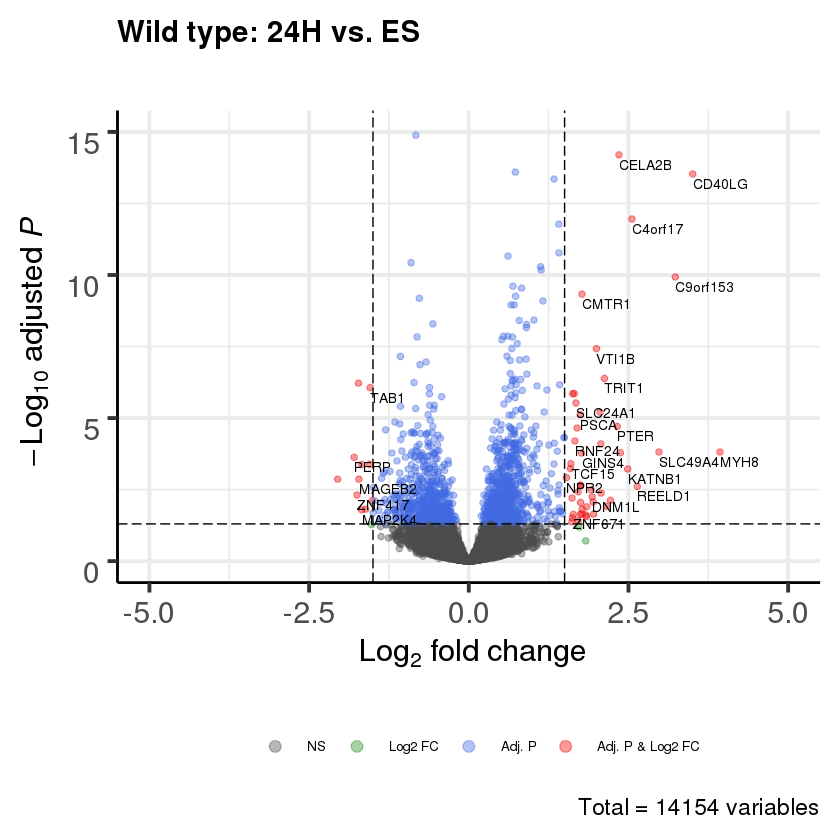

In [53]:
EnhancedVolcano(res3d.df, lab = res3d.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-5,5), ylim=c(0,15),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 24H vs. ES", subtitle="", pCutoff = .05, FCcutoff = 1.5,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

#### 5D vs. ES

In [54]:
res3e <- results(dds3, contrast = c('group','D5','ES'))

# add gene_name to result
if (all(rownames(res3e) == rownames(dds3))) {
    res3e.df <- cbind(res3e, 'gene_name' = mcols(dds3)$gene_name) %>% as.data.frame %>% rownames_to_column('gene_id') %>% filter(!is.na(padj))
}  else {
    print("Rownames don't match!")
}

In [55]:
res3e.df %>% head

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000003.14,127.80908,0.7887062,0.2626813,3.0025218,2.677528e-03,7.171543e-03,TSPAN6
ENSG00000000005.6,18.82296,-0.4373072,0.6754501,-0.6474309,5.173531e-01,6.024035e-01,TNMD
ENSG00000000457.14,226.78995,0.4187259,0.1604865,2.6091041,9.077962e-03,2.042258e-02,SCYL3
ENSG00000000460.17,281.12087,-0.3640334,0.1659779,-2.1932644,2.828833e-02,5.367606e-02,C1orf112
ENSG00000000938.13,174.76956,-1.0172629,0.2202482,-4.6187116,3.861301e-06,2.417962e-05,FGR
ENSG00000000971.15,95.12664,-0.6832256,0.2771840,-2.4648812,1.370587e-02,2.900315e-02,CFH


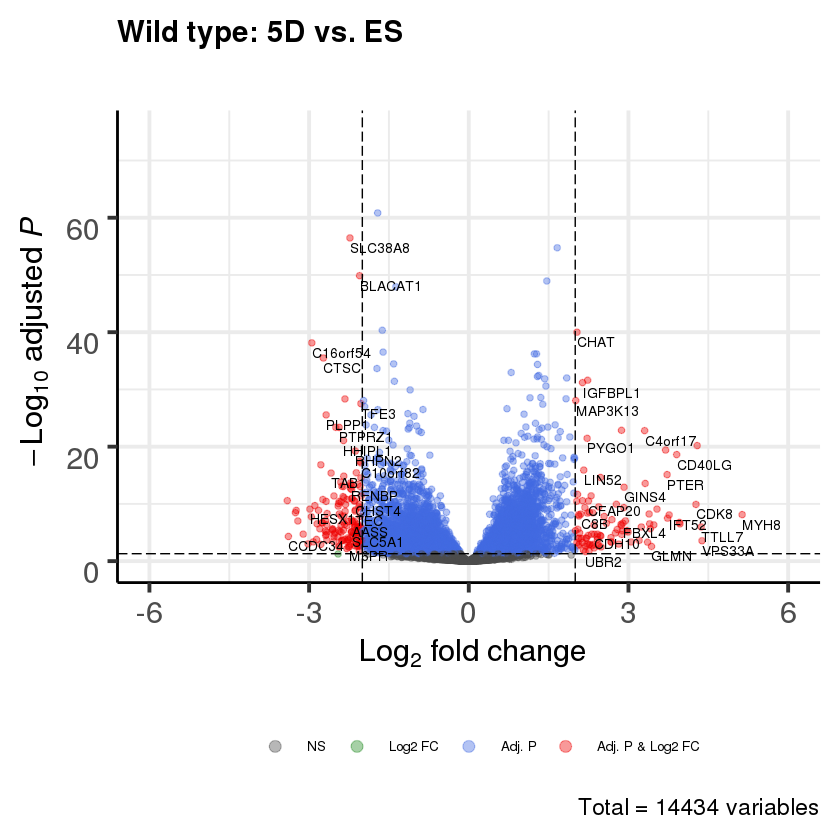

In [58]:
EnhancedVolcano(res3e.df, lab = res3e.df$gene_name, x='log2FoldChange',y='padj', xlim=c(-6,6), ylim=c(0,75),
                xlab = bquote(~Log[2]~ 'fold change'), ylab= bquote(~-Log[10]~adjusted~italic(P)),
                legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),legendPosition='bottom', legendLabSize = 8, 
                legendIconSize = 3.0, title = "Wild type: 5D vs. ES", subtitle="", pCutoff = .05, FCcutoff = 2,
                transcriptPointSize = 1.5, transcriptLabSize = 3.0, colAlpha = .4)
# selectLab = c('FHL3', 'STRAG') to only label key transcripts

### Get genes at each temporal point

In [59]:
sig_genes_3a <- res3a.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character
sig_genes_3b <- res3b.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character 
sig_genes_3c <- res3c.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character
sig_genes_3d <- res3d.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character
sig_genes_3e <- res3e.df %>% filter(padj < 0.05) %>% pull('gene_name') %>% unique %>% as.character

##### Number of genes significant in each tempral profile

In [60]:
res3e.df %>% filter(gene_name == 'ZBTB18')

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000179456.10,31.90549,2.05584,0.4856477,4.233193,2.303971e-05,0.0001170969,ZBTB18


In [61]:
counts(dds3, normalized=T) %>% as.data.frame %>% head #%>% rownames_to_column('gene_id') %>% filter(gene_id == 'ENSG00000036549') %>% t

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,101.43009,106.34806,93.59774,80.41350,141.50018,87.09302,153.28629,148.35069,162.29750,100.296363,161.73684,197.35865
ENSG00000000005.6,25.08486,12.51154,37.91301,16.08270,12.86365,16.74866,19.68815,27.62392,24.45579,4.973373,14.41219,13.51772
ENSG00000000457.14,218.12923,211.44497,190.74983,153.40422,260.78133,242.85554,196.88147,201.55232,238.44392,232.919652,292.24727,282.06967
ENSG00000000460.17,323.92190,256.48651,265.39107,258.56034,268.96729,339.16033,333.29221,284.42409,313.47872,277.680012,224.99036,227.09763
ENSG00000000938.13,158.14369,240.22151,190.74983,220.20928,205.81845,187.58497,142.03592,181.09016,175.08120,200.592725,106.49010,89.21692
ENSG00000000971.15,97.06751,88.83191,77.01080,60.61941,91.21499,133.98926,156.09888,118.68055,101.15803,101.125258,61.65216,54.07086


In [62]:
sig_genes_3a %>% length
sig_genes_3b %>% length
sig_genes_3c %>% length
sig_genes_3d %>% length
sig_genes_3e %>% length

[1] 0

[1] 13

[1] 824

[1] 1461

[1] 7496

##### Build a matrix that shows how significant genes show up at different time point.

 .|15H |1D|2D|4D|7D
:--:|:--:|:--:|:--:|:--:|:--:
Gene1|log2FC|log2FC|log2FC|log2FC|log2FC
Gene2| |log2FC|log2FC|log2FC|log2FC
...
GeneN| | | |log2FC|log2FC



In [63]:
length(c(1,1,1,1,1)==5) & is.numeric(c(1,1,1,1,1))

[1] TRUE

In [65]:
# A function to convert a vector of 5 binary numbers (represented in integer) into an integer. 
# This esentially represents/flags gene expression time profile.
# e.g. c(1,1,1,1,1) => 31, c(0,0,1,0,0) => 8
bit.like.to.int <- function(c) { 
    if (length(c) == 5 & is.numeric(c)){
        return(c[1]*2^4 + c[2]*2^3 + c[3]*2^2 + c[4]*2^1 + c[5]*2^0)
    }
    else {
        print("Vector must be numeric with a length of 5!")
    }
}

# DESeq2 results from each time point, combined into a list
res.all.times <- list(res3a.df, res3b.df, res3c.df, res3d.df, res3e.df) 

# first get all significant gene_ids from all 5 time point
sig.geneID.all.times <- c()
fdr.cutoff <- 0.05
for (df in res.all.times) { # iterate through the results from all 5 time points
    geneID.temp <- df %>% filter(padj < fdr.cutoff) %>% pull(gene_id) %>% as.character # get gene_ids of significant genes from results of all 5 time points
    sig.geneID.all.times <- c(sig.geneID.all.times, geneID.temp) # a list of gene ids for all the genes that are significant at any time point
}
sig.geneID.all.times <- unique(sig.geneID.all.times) # remove duplicates gene_ids

# create a expression table with Log2FC at all 5 time points. The rows are genes that are significant at any timepoint. 
# Value of NA means the gene is not significant at the given time point

#make a df of gene_id
expr.tbl <- sig.geneID.all.times %>% as.data.frame(stringsAsFactors=F) %>% rename('.'='gene_id')

#create a list of log2FC for all the genes listed in expr.tbl at each time point
FC.all.times <- c()
for (df in res.all.times) {
    x <- expr.tbl %>% left_join(df[df$padj < fdr.cutoff, c('gene_id', 'log2FoldChange')], c('gene_id')) %>% 
        select(log2FoldChange) %>% pull(log2FoldChange)
    FC.all.times <- c(FC.all.times, list(x)) # log2FC for the gene_id
}

#add log2FC at each time point as a column, then left join gtf_lookup to add gene name
expr.tbl <- expr.tbl %>% add_column('1H' = FC.all.times[[1]]) %>% add_column('4H' = FC.all.times[[2]]) %>%
             add_column('16H' = FC.all.times[[3]]) %>% add_column('24H' = FC.all.times[[4]]) %>%
             add_column('5D' = FC.all.times[[5]]) %>% left_join(gtf_lookup, 'gene_id')


# create a logic matrix where 1: this gene is significant at this time point, and 0: not
logic.matrix <- apply(expr.tbl[,c(2:6)], MARGIN = 2, function(x) {!is.na(x)}) %>% as.data.frame %>% 
        mutate_all(funs(as.integer))

# expression time profile flag. e.g. a number of 7 represents this gene is activated from D2 through D7, while 1 means only activated on D7
expr.flags <- c()
for (i in 1:dim(logic.matrix)[1]) {
    x <- logic.matrix[i,] %>% as.numeric # convert each row e.g.[1,0,0,0,0] into a numeric vector of 5 elements, eg.c(1,0,0,0,0)
    x <- bit.like.to.int(x) # calculate bit value (represented in int, eg. 00100 = 8)
    expr.flags <- c(expr.flags, x)
}

expr.tbl <- cbind(expr.tbl, expr.flag=expr.flags) # add expression flags 
expr.tbl <- expr.tbl[,c(1,7:8,2:6)]

In [66]:
expr.tbl %>% head
expr.tbl %>% dim

gene_id,gene_name,expr.flag,1H,4H,16H,24H,5D
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000008083.14,JARID2,15,NA,-0.5053448,-0.5660956,-0.5400255,-0.6196536
ENSG00000065621.15,GSTO2,15,NA,0.5173015,0.9081700,0.8261315,0.7374443
ENSG00000078699.21,CBFA2T2,15,NA,0.6676727,1.0501913,1.3355086,1.5444512
ENSG00000108405.4,P2RX1,15,NA,0.7844950,0.7146673,0.8816750,0.7040117
ENSG00000130707.17,ASS1,8,NA,0.6512434,NA,NA,NA
ENSG00000149131.15,SERPING1,15,NA,0.6852672,0.8276870,1.1241099,1.8394373


[1] 7806    8

In [67]:
#TF list
tflist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/TFlist.csv', stringsAsFactors = F, col.names='gene_name') %>% pull(var = gene_name)

In [68]:
correct_tf_gene_name <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/Refseq_to_Gencode_genenames.csv', header = F, stringsAsFactors = F) %>% rename('V1'='HGNC', 'V2'='Gencode')

In [69]:
correct_tf_gene_name %>% head

HGNC,Gencode
<chr>,<chr>
AES,TLES
ANKRD32,SLF1
CCRN4L,NOCT
CNOT2,AC092881.1
CRAMP1L,CRAMP1
FAIM3,FCMR


In [133]:
correct_tf_gene_name

HGNC,Gencode
<chr>,<chr>
AES,TLES
ANKRD32,SLF1
CCRN4L,NOCT
CNOT2,AC092881.1
CRAMP1L,CRAMP1
FAIM3,FCMR
HDGFRP2,HDGFL2
HKR1,ZNF875
MKL1,MRTFA


In [206]:
gtf_lookup %>% filter(gene_id == 'ENSG00000198039.11')

gene_name,gene_id
<fct>,<chr>
AC092161.1,ENSG00000198039.11


In [549]:
correct_tf_gene_name %>% filter(HGNC == 'ZZZ3') %>% pull(Gencode)

[1] "AC118549.1"

In [555]:
tflist[1988]

[1] "AC118549.1"

In [558]:
which(tflist == 'AC092161.1')

[1] 1754 1773

In [552]:
correct_tf_gene_name$Gencode[1]

[1] "TLES"

In [554]:
for (tf in tflist) {
    if (tf %in% correct_tf_gene_name$HGNC) {
        new_name <- correct_tf_gene_name %>% filter(HGNC == tf) %>% pull(Gencode)
        tflist[which(tflist == tf)] <- new_name
    }
}

In [518]:
tflist %>% head

[1] "AATF"  "ABL1"  "ABT1"  "ABTB1" "ADNP"  "AEBP1"

In [70]:
#120 hit list
hitlist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/HS_td-VStd+_td-VSdox120.csv', header = F, stringsAsFactors = F) %>% pull

In [71]:
hitlist %>% t

PHOX2A,TAF1L,TFEB,VAX2,SNAI2,ELK3,ISL2,ZBTB43,ZNF200,MLLT6,⋯,ZBTB18,CHD5,CTNNB1,ZNF554,UBE2K,HTATIP2,NEUROG3,SMAD3,LHX4,PRDM6


In [72]:
expr.tbl <- expr.tbl %>% mutate(isTF=if_else(gene_name %in% tflist, 'Yes', 'No')) %>% 
             mutate(isHIT=if_else(gene_name %in% hitlist, 'Yes', 'No'))

In [73]:
expr.tbl %>% write.csv('ATAC_FoldChangeByTimePoints_geneRegion.csv', row.names=F)

In [74]:
ano3 <- coldata3

In [75]:
tf.heatmap.genes.3e <- res3e_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character
cnts3_tf[,c(2:16)] %>% filter(gene_name %in% tf.heatmap.genes.3e) %>% column_to_rownames('gene_name') %>% mutate_all(quadroot) %>% as.matrix %>%
                pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, annotation = ano3, fontsize=8, treeheight_row=0,
                main = paste0('+DOX vs. ES at 7D, Screened TF Genes (fdr<',fdr,', log2FC>',FC.threshold,')'))

ERROR: Error in eval(lhs, parent, parent): object 'res3e_tf' not found


##### genes that are significant from 1H to 5D

In [76]:
sig_genes_3a %>% intersect(sig_genes_3b) %>% intersect(sig_genes_3c) %>% intersect(sig_genes_3d) %>%
                 intersect(sig_genes_3e) %>% length

[1] 0

##### genes that become significant at 4H and continues to be significant at 16H, 24H and Day 5

In [77]:
sig_genes_3b %>%  setdiff(sig_genes_3a)  %>% intersect(sig_genes_3c) %>% 
            intersect(sig_genes_3d) %>% intersect(sig_genes_3e) %>% length

[1] 10

##### genes that become significant at 16H and continues to be significant at 24H and Day 5

In [78]:
sig_genes_3c %>% setdiff(unique(c(sig_genes_3a,sig_genes_3b))) %>% intersect(sig_genes_3d) %>% intersect(sig_genes_3e) %>% length

[1] 459

##### genes that become significant at 24H and continues to be significant at Day 5

In [79]:
sig_genes_3e %>% setdiff(unique(c(sig_genes_3a,sig_genes_3b, sig_genes_3c))) %>% intersect(sig_genes_3e) %>% length

[1] 6858

##### genes that are only significant at Day 5

In [80]:
sig_genes_3e %>% setdiff(unique(c(sig_genes_3a,sig_genes_3b, sig_genes_3c, sig_genes_3d))) %>% length

[1] 6069

## Zoom in on ~2000 screened TF

In [81]:
#TF list
tflist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/TFlist.csv', stringsAsFactors = F, col.names='gene_name') %>% pull(var = gene_name)

In [82]:
tflist[1:5]
length(tflist)

[1] "AATF"  "ABL1"  "ABT1"  "ABTB1" "ADNP"

[1] 1988

#### Result for each temporal stage
`gene`,`padj`,`log2FoldChange` for each temporal point (15H - 7D) for the 1988 TF genes.

Selection criteria:
- `padj` is not na
- `gene_name` in `tflist`

In [83]:
res3d.df %>% tail

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
14149,ENSG00000287694.1,168.7189,0.15740471,0.2000510,0.7868230,0.431385474,0.69095937,AC106741.1
14150,ENSG00000287725.1,439.8084,-0.38663737,0.1273706,-3.0355312,0.002401124,0.02955262,AP003071.5
14151,ENSG00000287856.1,343.2083,0.18576867,0.1347959,1.3781478,0.168157650,0.42623628,AL445524.2
14152,ENSG00000287908.1,153.9782,-0.11214357,0.2175190,-0.5155576,0.606163405,0.81308158,AC025165.6
14153,ENSG00000288000.1,342.8802,-0.08100188,0.1454253,-0.5569999,0.577527515,0.79402201,AL031681.2
14154,ENSG00000288053.1,205.0773,-0.21605346,0.1730019,-1.2488502,0.211719870,0.48062278,AC231657.3


In [84]:
# get DGE result, namely FC and padj, for each temproal point
res3a_tf <- res3a.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)
res3b_tf <- res3b.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)
res3c_tf <- res3c.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)
res3d_tf <- res3d.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)
res3e_tf <- res3e.df %>% filter((gene_name %in% tflist) & (!is.na(padj))) %>% select(gene_name, gene_id, padj, log2FoldChange)

In [85]:
# Determine and annotate whether a TF screen listed gene is up or down regulated
fdr = 0.05
FC.threshold = 1.5

In [86]:
res3a_tf <- res3a_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 
res3b_tf <- res3b_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 
res3c_tf <- res3c_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 
res3d_tf <- res3d_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 
res3e_tf <- res3e_tf %>% mutate(DGE=case_when(padj < fdr & log2FoldChange > FC.threshold ~ 'Up', 
                                  padj < fdr & log2FoldChange < -FC.threshold ~ 'Down',
                                  padj < fdr & log2FoldChange >= -FC.threshold & log2FoldChange <= FC.threshold ~ 'No Change',
                                  padj >= fdr ~ 'No Change')) 

In [87]:
res3a_tf %>% head

gene_name,gene_id,padj,log2FoldChange,DGE
<chr>,<chr>,<dbl>,<dbl>,<chr>
ARX,ENSG00000004848.8,0.9998159,-0.01294015,No Change
UPF1,ENSG00000005007.12,0.9998159,0.38408176,No Change
HOXA11,ENSG00000005073.5,0.9998159,0.61032828,No Change
POLR2J,ENSG00000005075.15,0.9998159,0.64063068,No Change
MEOX1,ENSG00000005102.13,0.9998159,-0.37245599,No Change
CREBBP,ENSG00000005339.14,0.9998159,-0.23466359,No Change


##### Summary plot for TF screen selected genes that are up/down regulated

In [88]:
# summarize gene counts for TF screen selected genes
c <- c()
for (l in list(res3a_tf, res3b_tf, res3c_tf, res3d_tf, res3e_tf)) {
    gcount <- l %>% group_by(DGE) %>% summarize( "gene_count"=n()) %>% pull(gene_count) # get the count of genes
    c <- c(c,gcount)
}

tfs.bar.data <- data.frame(matrix(c, nrow=3))

colnames(tfs.bar.data) = c('1H', '4H', '16', '24H','5D')
rownames(tfs.bar.data) = c('Down', 'No Change', 'Up')

tfs.bar.data <- tfs.bar.data %>% gather(condition, gene_counts) %>% add_column(DGE=rep(c('Down', 'No Change', 'Up'),5), .before=2)

ERROR: Error in names(x) <- value: 'names' attribute [5] must be the same length as the vector [3]


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'condition' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. past

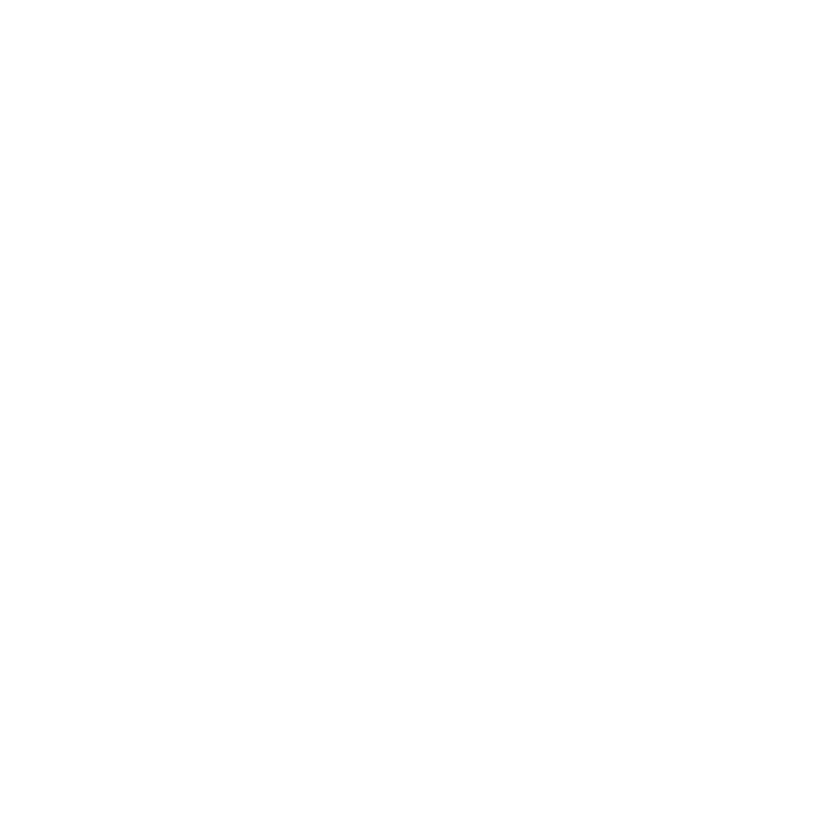

In [89]:
ggplot(data = tfs.bar.data) + geom_bar(aes(x=condition, y=gene_counts, fill=DGE),position=position_fill(reverse = TRUE), stat="identity") +
            labs(y="% of Screened Gene", x="Temporal", title = "Accessible Promoter Region") +
            scale_fill_manual(name='+DOX vs. ES', values=c('lightslateblue', 'grey80', 'tan2')) +
            theme(axis.text = element_text(size = 20), axis.title=element_text(size=20, face='bold'), legend.position = "bottom", 
                  plot.title = element_text(size = 20, face = 'bold')) +
            scale_y_continuous(labels = scales::percent)

##### Normalized counts of all TF screen genes, and plot heatmap

In [90]:
cnts3_tf <- (counts(dds3, normalized=T) + 1e-06) %>% as.data.frame %>% rownames_to_column('gene_id') %>%
            inner_join(gtf_lookup, 'gene_id') %>% inner_join(data.frame(gene_name=tflist), 'gene_name')

Warning message:
“Column `gene_name` joining factors with different levels, coercing to character vector”

In [91]:
cnts3_tf %>% head

gene_id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000004848.8,405.72036,359.08111,380.31488,378.56203,373.04594,333.29830,399.38814,346.83369,294.02526,256.12873,241.00391,196.45747,ARX
ENSG00000005007.12,148.32788,165.15229,219.18459,189.28101,155.53326,140.68873,157.50518,139.14272,121.16731,189.81708,150.52736,164.01495,UPF1
ENSG00000005073.5,49.07908,47.54384,77.01080,70.51646,76.01250,60.29517,53.43926,61.38649,47.24414,49.73373,36.03049,41.45433,HOXA11
ENSG00000005075.15,42.53520,68.81345,99.52165,72.99072,51.45461,47.73368,40.78259,33.76257,33.34880,46.41815,28.02371,28.83779,POLR2J
ENSG00000005102.13,59.98554,95.08768,78.19558,40.82532,65.48769,61.13260,68.90852,51.15541,53.35808,71.28502,56.04742,55.87323,MEOX1
ENSG00000005339.14,170.14080,258.98881,176.53245,186.80675,197.63249,189.25984,135.00444,153.46623,192.86723,229.60407,170.54430,193.75393,CREBBP


In [92]:
cnts3_tf <- cnts3_tf[,c(1,14,2:13)]

In [93]:
# this particular gene has two gene IDs with different expressing profile.
cnts3_tf[,1:2] %>% group_by(gene_name) %>% summarise(n_geneIDs=n_distinct(gene_id)) %>% filter(n_geneIDs > 1)
cnts3_tf %>% filter(gene_name == 'MATR3')

gene_name,n_geneIDs
<chr>,<int>
MATR3,2


gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000015479.18,MATR3,95.97686,115.1061,136.2499,116.2903,114.6035,116.4032,98.44074,115.6112,84.48363,90.34962,59.25013,65.78622
ENSG00000280987.4,MATR3,401.35778,496.7080,476.2822,588.8743,521.5627,474.8245,435.95184,565.7788,475.77622,494.85065,479.60579,485.73659


In [94]:
cnts3_tf <- filter(cnts3_tf, gene_id != 'ENSG00000280987.4') # remove one gene_id from genes with multiple gene_ids

In [236]:
cnts3_tf %>% head

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000188290.10,HES4,92.389510,248.953790,98.450204,217.440925,143.287114,138.866978,194.626222,159.470196,181.262605,166.554779,113.177888,172.229567
ENSG00000157933.10,SKI,193.903908,0.000001,68.915143,72.000307,172.195917,248.912507,144.495226,127.958121,195.010049,159.382563,129.769411,193.085491
ENSG00000142611.17,PRDM16,0.000001,0.000001,0.000001,188.640802,0.000001,0.000001,0.000001,0.000001,28.004055,0.000001,0.000001,0.000001
ENSG00000078900.15,TP73,271.465471,260.533037,398.020106,388.801653,300.400176,241.052113,193.151781,158.515284,183.808428,86.863497,62.810766,78.714295
ENSG00000116254.18,CHD5,120.904790,115.792461,180.023228,146.880625,159.626872,59.389652,0.000001,109.814806,103.360418,116.349272,65.180983,67.277175
ENSG00000069812.11,HES2,38.780782,0.000001,0.000001,0.000001,0.000001,44.542239,0.000001,114.589363,0.000001,0.000001,39.701145,0.000001


In [115]:
# ano3 <- as.data.frame(colData(dds3)[,c('condition','group')])
ano3 <- coldata3

In [116]:
quadroot <- function (x) { # function to help decrease range of read counts. Easier for heatmap visulization
    return(x^(1/4))
}

In [243]:
cnts3_tf %>% head

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000188290.10,HES4,92.389510,248.953790,98.450204,217.440925,143.287114,138.866978,194.626222,159.470196,181.262605,166.554779,113.177888,172.229567
ENSG00000157933.10,SKI,193.903908,0.000001,68.915143,72.000307,172.195917,248.912507,144.495226,127.958121,195.010049,159.382563,129.769411,193.085491
ENSG00000142611.17,PRDM16,0.000001,0.000001,0.000001,188.640802,0.000001,0.000001,0.000001,0.000001,28.004055,0.000001,0.000001,0.000001
ENSG00000078900.15,TP73,271.465471,260.533037,398.020106,388.801653,300.400176,241.052113,193.151781,158.515284,183.808428,86.863497,62.810766,78.714295
ENSG00000116254.18,CHD5,120.904790,115.792461,180.023228,146.880625,159.626872,59.389652,0.000001,109.814806,103.360418,116.349272,65.180983,67.277175
ENSG00000069812.11,HES2,38.780782,0.000001,0.000001,0.000001,0.000001,44.542239,0.000001,114.589363,0.000001,0.000001,39.701145,0.000001


##### Plot heatmaps of TF screened genes that are sigificant and pass FC threshold

In [96]:
tf.heatmap.genes.3c <- res3c_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character
cnts3_tf[,c(2:14)] %>% filter(gene_name %in% tf.heatmap.genes.3c) %>% column_to_rownames('gene_name') %>% as.matrix %>% apply(2, sqrt) %>%
                pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, annotation = ano3, fontsize=6, treeheight_row=20,
                main = paste0('Wild type 16H vs. ES, Screened TF Genes (fdr<',fdr,', log2FC>',FC.threshold,')'))

ERROR: Error in hclust(d, method = method): must have n >= 2 objects to cluster


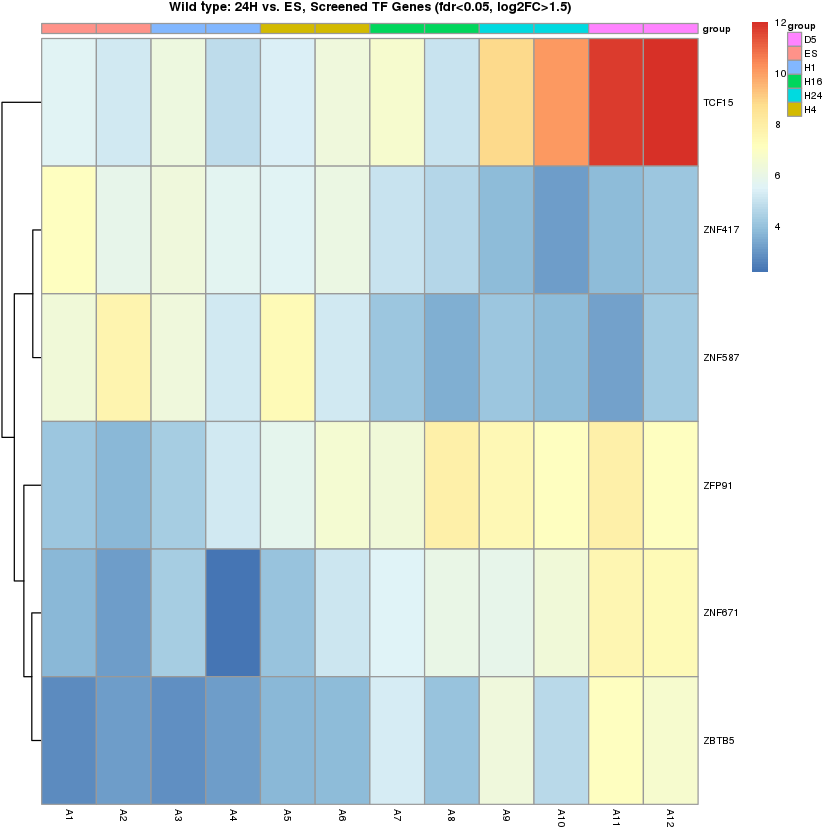

In [97]:
tf.heatmap.genes.3d <- res3d_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character
cnts3_tf[,c(2:14)] %>% filter(gene_name %in% tf.heatmap.genes.3d) %>% column_to_rownames('gene_name') %>% as.matrix %>% apply(2, sqrt) %>%
                pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, annotation = ano3, fontsize=6, treeheight_row=20,
                main = paste0('Wild type: 24H vs. ES, Screened TF Genes (fdr<',fdr,', log2FC>',FC.threshold,')'))

In [98]:
res3e_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character

[1] "HMG20B"  "TFE3"    "CBFA2T2" "SP140"   "ZNF510"  "ZNF671"  "ANKRD10"
 [8] "HIF1A"   "E2F1"    "RBBP7"   "TRIP4"   "KLF1"    "AEBP1"   "NANOG"  
[15] "HAND1"   "CEBPZ"   "IRF6"    "RNF2"    "WWP1"    "HOXC11"  "HIF3A"  
[22] "SNRPB"   "TCF15"   "MCM8"    "HABP4"   "ZSWIM4"  "TRIM22"  "BTG1"   
[29] "RXRG"    "PARP1"   "SHPRH"   "ZNF157"  "RBMX"    "ZNF18"   "ZIC3"   
[36] "FUBP1"   "REL"     "ELF3"    "HESX1"   "ZNF12"   "ZBTB5"   "PRDM10" 
[43] "NFXL1"   "PYGO1"   "ZNF483"  "FOSL1"   "ARID3B"  "ZFP91"   "ZNF248" 
[50] "ZNF587"  "POU5F1"  "ZNF611"  "ZNF254"  "RBM14"   "ZNF512"  "ZNF486" 
[57] "ZNF578"  "DCP1A"

In [99]:
cnts3_tf %>% head

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000004848.8,ARX,405.72036,359.08111,380.31488,378.56203,373.04594,333.29830,399.38814,346.83369,294.02526,256.12873,241.00391,196.45747
ENSG00000005007.12,UPF1,148.32788,165.15229,219.18459,189.28101,155.53326,140.68873,157.50518,139.14272,121.16731,189.81708,150.52736,164.01495
ENSG00000005073.5,HOXA11,49.07908,47.54384,77.01080,70.51646,76.01250,60.29517,53.43926,61.38649,47.24414,49.73373,36.03049,41.45433
ENSG00000005075.15,POLR2J,42.53520,68.81345,99.52165,72.99072,51.45461,47.73368,40.78259,33.76257,33.34880,46.41815,28.02371,28.83779
ENSG00000005102.13,MEOX1,59.98554,95.08768,78.19558,40.82532,65.48769,61.13260,68.90852,51.15541,53.35808,71.28502,56.04742,55.87323
ENSG00000005339.14,CREBBP,170.14080,258.98881,176.53245,186.80675,197.63249,189.25984,135.00444,153.46623,192.86723,229.60407,170.54430,193.75393


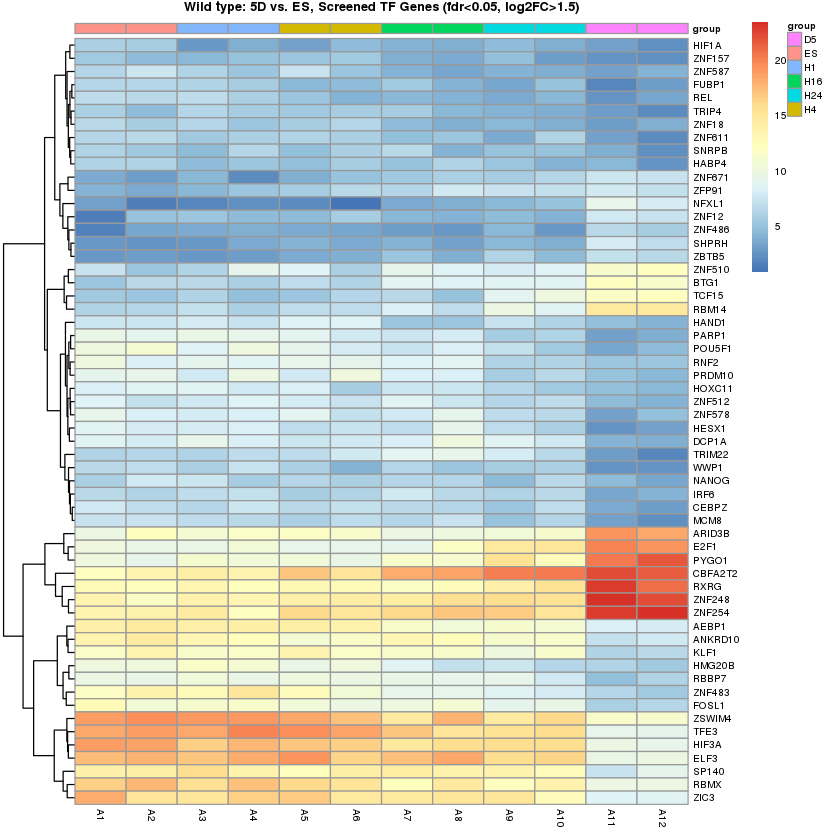

In [100]:
tf.heatmap.genes.3e <- res3e_tf %>% filter(DGE != 'No Change' & padj < fdr & abs(log2FoldChange) > abs(FC.threshold)) %>% pull(gene_name) %>% as.character
cnts3_tf[,c(2:14)] %>% filter(gene_name %in% tf.heatmap.genes.3e) %>% column_to_rownames('gene_name') %>% as.matrix %>% apply(2, sqrt) %>%
                pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, annotation = ano3, fontsize=6, treeheight_row=40,
                main = paste0('Wild type: 5D vs. ES, Screened TF Genes (fdr<',fdr,', log2FC>',FC.threshold,')'))

In [101]:
for (x in list(tf.heatmap.genes.3a, tf.heatmap.genes.3b, tf.heatmap.genes.3c, tf.heatmap.genes.3d, tf.heatmap.genes.3e)) {
    print(length(x))
}

ERROR: Error in eval(expr, envir, enclos): object 'tf.heatmap.genes.3a' not found


In [102]:
tf.heatmap.genes.3a %>% sort %>% paste(" ", collapse="") # 1H up or down regulated

ERROR: Error in eval(lhs, parent, parent): object 'tf.heatmap.genes.3a' not found


In [103]:
tf.heatmap.genes.3b %>% sort %>% paste(" ", collapse="") # 4H up or down regulated

ERROR: Error in eval(lhs, parent, parent): object 'tf.heatmap.genes.3b' not found


In [104]:
tf.heatmap.genes.3c %>% sort %>% paste(" ", collapse="") # 16H up or down regulated

[1] "  "

In [105]:
tf.heatmap.genes.3d %>% sort %>% paste(" ", collapse="") # 14H up or down regulated

[1] "TCF15  ZBTB5  ZFP91  ZNF417  ZNF587  ZNF671  "

In [106]:
tf.heatmap.genes.3e %>% sort %>% paste(" ", collapse="") # 5D up or down regulated

[1] "AEBP1  ANKRD10  ARID3B  BTG1  CBFA2T2  CEBPZ  DCP1A  E2F1  ELF3  FOSL1  FUBP1  HABP4  HAND1  HESX1  HIF1A  HIF3A  HMG20B  HOXC11  IRF6  KLF1  MCM8  NANOG  NFXL1  PARP1  POU5F1  PRDM10  PYGO1  RBBP7  RBM14  RBMX  REL  RNF2  RXRG  SHPRH  SNRPB  SP140  TCF15  TFE3  TRIM22  TRIP4  WWP1  ZBTB5  ZFP91  ZIC3  ZNF12  ZNF157  ZNF18  ZNF248  ZNF254  ZNF483  ZNF486  ZNF510  ZNF512  ZNF578  ZNF587  ZNF611  ZNF671  ZSWIM4  "

---

# Analyze by promoter region peaks 
(not by differential analysis on readcounts of peaks)

In [307]:
promoters <- counts(dds3, normalized=T) %>% as.data.frame %>% add_column(gene_name = mcols(dds3)$gene_name, .before = 'A1') %>% rownames_to_column('gene_id')

In [308]:
promoters %>% head

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000187634.12,SAMD11,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,0.0000,0.0000,0.00000,40.64255,58.07033,0.00000
ENSG00000188976.11,NOC2L,63.87423,0.00000,0.00000,266.4011,187.2788,0.00000,0.0000,142.2818,99.79626,71.72215,0.00000,55.84005
ENSG00000187961.14,KLHL17,63.87423,0.00000,0.00000,266.4011,187.2788,0.00000,0.0000,142.2818,99.79626,71.72215,0.00000,55.84005
ENSG00000187583.10,PLEKHN1,44.48384,114.34505,90.01161,138.2406,0.0000,92.57798,0.0000,124.1385,79.42968,98.81719,29.62772,0.00000
ENSG00000187642.9,PERM1,0.00000,44.86958,0.00000,0.0000,0.0000,0.00000,0.0000,0.0000,57.02644,0.00000,0.00000,26.91087
ENSG00000188290.10,HES4,92.38951,248.95379,98.45020,217.4409,143.2871,138.86698,194.6262,159.4702,181.26260,166.55478,113.17789,172.22957


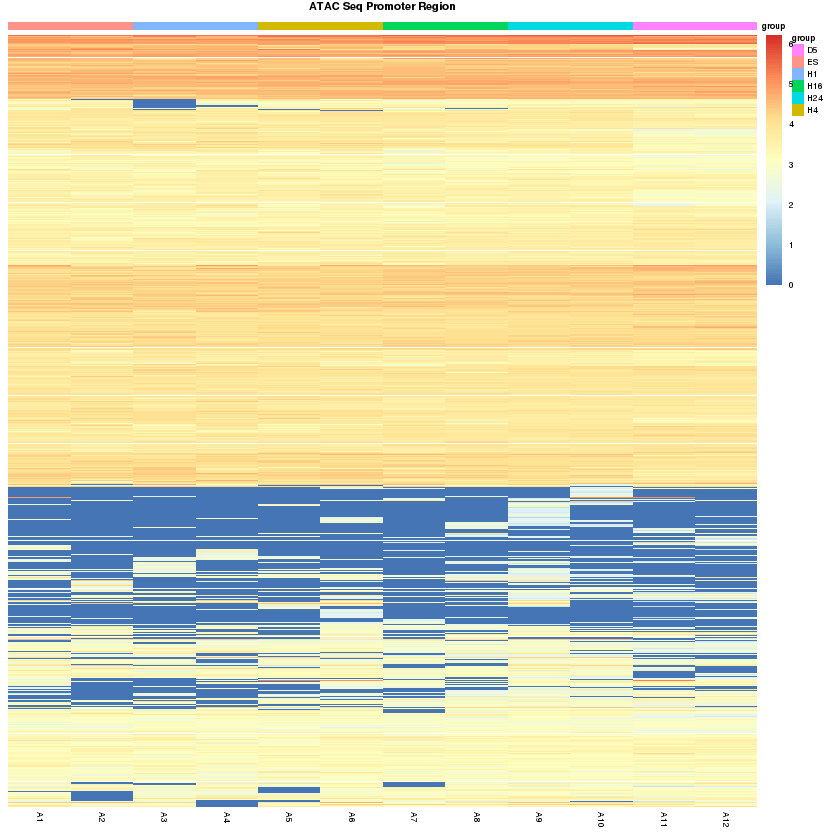

In [314]:
promoters[,c(1,3:14)] %>% column_to_rownames('gene_id') %>% as.matrix %>% apply(2, quadroot) %>%
                pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, annotation = ano3, fontsize=5, treeheight_row=0,
                main = paste0('ATAC Seq Promoter Region'))

In [315]:
# promoter region open at 1H

In [340]:
promoters %>% filter((A3 > 0 & A4 > 0) & A1 + A2 + A5 + A6 + A7 + A8 + A9 + A10 + A11 + A12 < 1)

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000204542.2,C6orf15,0,0,30.94149,109.44046,0,0,0,0,0,0,0,0
ENSG00000204540.10,PSORS1C1,0,0,30.94149,109.44046,0,0,0,0,0,0,0,0
ENSG00000179142.2,CYP11B2,0,0,29.53506,24.48010,0,0,0,0,0,0,0,0
ENSG00000134588.12,USP26,0,0,71.72800,38.88017,0,0,0,0,0,0,0,0


In [402]:
promoters %>% filter(str_detect(gene_name, 'ZBTB18'))

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000179456.10,ZBTB18,351.3083,263.4278,402.2394,276.4812,326.7952,365.9451,401.048,426.8454,464.3581,408.8163,433.1573,419.8096


In [405]:
promoter_peaks %>% filter(gene_id == 'ENSG00000179456.10')

gene_id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000179456.10,1,1,1,1,1,1,1,1,1,1,1,1


In [344]:
# promoter region open at 5D only
promoters %>% filter((A11 > 0 & A12 > 0) & A1 + A2 + A5 + A6 + A7 + A8 + A9 + A10 + A3 + A4 < 1)

gene_id,gene_name,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000157216.15,SSBP3,0,0,0,0,0,0,0,0,0,0,18.36919,26.910870
ENSG00000158488.16,CD1E,0,0,0,0,0,0,0,0,0,0,11.25853,18.164837
ENSG00000094963.14,FMO2,0,0,0,0,0,0,0,0,0,0,28.44261,25.565326
ENSG00000179915.23,NRXN1,0,0,0,0,0,0,0,0,0,0,27.85006,42.384620
ENSG00000168878.17,SFTPB,0,0,0,0,0,0,0,0,0,0,10.07342,12.109891
ENSG00000183054.11,RGPD6,0,0,0,0,0,0,0,0,0,0,9.48087,6.727717
ENSG00000188674.11,C2orf80,0,0,0,0,0,0,0,0,0,0,27.25750,45.748479
ENSG00000123992.19,DNPEP,0,0,0,0,0,0,0,0,0,0,27.85006,35.656902
ENSG00000171951.5,SCG2,0,0,0,0,0,0,0,0,0,0,61.03310,48.439566


##### number of peaks per gene at different time point

In [346]:
promoter_peaks <- read.delim(file = 'ATAC_Promoter_NumberofPeaks.txt', header = T, sep = '\t', stringsAsFactors = F) %>% mutate_all(~ replace(.x, is.na(.x), 0))

In [348]:
promoter_peaks %>% head

gene_id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972.5,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227232.5,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000278267.1,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000243485.5,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000284332.1,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0,0,0,0,0,0,0,0


In [358]:
keep4 <- promoter_peaks %>% column_to_rownames('gene_id') %>% rowSums %>% `>`(1)

In [362]:
promoter_peaks[keep4,] %>% filter((A11 > 0 & A12 > 0) & A1 + A2 + A5 + A6 + A7 + A8 + A9 + A10 + A3 + A4 < 1)

gene_id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000157216.15,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000158488.16,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000094963.14,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000179915.23,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000168878.17,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000183054.11,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000188674.11,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000123992.19,0,0,0,0,0,0,0,0,0,0,1,1
ENSG00000171951.5,0,0,0,0,0,0,0,0,0,0,1,1


# $$X=PA$$
# $$x_{ij} = \sum\limits_{k \in TFs} b_{ik}a_{kj}$$



# Other

> **_If you can't explain it simply, you don't understand it well enough._**

## Check gene names compatibility
Check to see if the gene names in Congyi's screen data is the same as gencode annotation. Congyi's gene names are likely NCBI Refseq's names.